In [1]:
from pathlib import Path
import json
from collections import defaultdict

import numpy as np
import scipy.io
import networkx as nx

import pandas as pd
from pandas import DataFrame, Series

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.animation import FuncAnimation

from numpy.lib.stride_tricks import sliding_window_view
from opt_einsum import contract
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

import pickle
from datetime import date

## Functions and Globals

In [2]:
def plot_trace(data, title=None, xlabel="Time", ylabel="Calcium Level (z-scored)", avg_timestep=None):
    if avg_timestep:
        xlabel=f"Time (steps of {avg_timestep}s)"
    DataFrame(data).plot(
        title=title, 
        xlabel=xlabel, 
        ylabel=ylabel,
        legend=False)
    # hacky autoticker
    # appx_num_ticks = 8
    # tick_scale = 5 * 10**(round(np.log10(len(data)))-2)
    # tick_step = tick_scale * round(len(data)/(appx_num_ticks*tick_scale))
    # plt.xticks(np.arange(0, len(data) + tick_step, tick_step), np.arange(start, start + len(data) + tick_step, tick_step))
    plt.show()

In [3]:
# Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", make_cbar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if make_cbar:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    else:
        cbar = None

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90)

    # Turn spines off and create white grid.
    # ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    # ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

## Classes

### Connectome

In [4]:
class Connectome(nx.MultiDiGraph):
    def __init__(self, filepath=None, sheet_name=None, incoming_graph_data=None, **attr):
        super().__init__(incoming_graph_data, **attr)
        if filepath:
            self.load(filepath, sheet_name)
        
    def load(self, filepath, sheet_name):
        excel_connectome = pd.read_excel(filepath, sheet_name)
        table = excel_connectome.values[1:,2:]

        neuron_names = set().union(table[1:,0], table[0,1:])
        neuron_names = {x for x in neuron_names if x == x} #remove nans
        neuron_names = sorted(list(neuron_names))

        edge_list = []

        def isnan(x):
            return isinstance(x, float) and np.isnan(x)

        for r in range(1,len(table)):
            for c in range(1,len(table[r])):
                if isnan(table[r][c]) or isnan(table[r][0]) or isnan(table[0][c]):
                    continue
                edge_list.append((table[r][0], table[0][c], table[r][c]))

        self.add_nodes_from(neuron_names)
        self.add_weighted_edges_from(edge_list)

    def get_weight(self, neuron1, neuron2):
        return self.get_edge_data(neuron1, neuron2)['weight'] if self.get_edge_data(neuron1, neuron2) else 0
    
    def get_relevant_neurons(self, neuron):
        # relevant_neurons = set(self)
        # relevant_neurons.remove(neuron)
        return set().union(self.predecessors(neuron), self.successors(neuron)) #[neuron], 

#### Initializing Connectomes

In [5]:
FAKE_CONNECTOME = Connectome("datasets/fake_test_data/fake_connectome.xlsx", sheet_name="S1S2N1")

CONNECTOME = Connectome()

CONNECTOME.load("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male chemical")
CONNECTOME.load("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male gap jn symmetric")
CONNECTOME.load("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male gap jn asymmetric")

### TraceObject

In [6]:
class TraceObject:
    """
    A class used to store traces and related info from a single recording of one worm.

    Attributes
    ----------
    uid : str
        unique identifier associated with this trace data
    avg_timestep : float
        average length in seconds that one timestep represents
    num_neurons : int
        number of neurons recorded in trace data
    num_timesteps : int
        length of the recording in number of timesteps
    traces : np.ndarray(shape=(num_neurons, num_timesteps), dtype=float)
        a matrix containing recorded activations of each neuron at each timestep
    _label_to_index_map : defaultdict(lambda : -1)
        map from neuron labels to their indices in traces matrix
    _index_to_label_map : defaultdict(str)
        map from row indices of traces matrix to neuron labels

    Methods
    -------
    get_label(index)
        Returns label of neuron associated with index-th row of traces, or "" if unlabeled

    get_index(label)
        Returns index of labeled neuron in traces, or -1 if label not found
    """

    def __init__(
            self,
            uid,
            avg_timestep,
            traces,
            labels
    ):
        self.uid = uid
        self.avg_timestep = avg_timestep

        self.traces = traces
        self.num_neurons = self.traces.shape[0]
        self.num_timesteps = self.traces.shape[1]

        self._label_to_index_map = defaultdict(lambda : -1)  # will output -1 if label not found
        self._index_to_label_map = defaultdict(str)          # will output "" if index unlabeled
        
        if isinstance(labels, list):
            for index, label in enumerate(labels):
                self._label_to_index_map[label] = index
                self._index_to_label_map[index] = label
        if isinstance(labels, dict):
            for a,b in labels.items():
                if isinstance(a, int) and isinstance(b, str):
                    index, label = a, b
                elif isinstance(b, int) and isinstance(a, str):
                    index, label = b, a
                else:
                    ValueError(f"labels entry {(a,b)} does not contain an index and a neuron label.")
                self._label_to_index_map[label] = index
                self._index_to_label_map[index] = label
        
    def from_www_json(json_filepath):
        with open(json_filepath) as trace_file:
            trace_json = json.load(trace_file)

        uid = 'www_' + trace_json['uid']
        avg_timestep = round(trace_json['avg_timestep']*60, 1) #rounded
        traces = np.array(trace_json['trace_array'])

        if trace_json['num_neurons'] != traces.shape[0]:
            raise ValueError(f"Faulty wormwideweb Dataset (uid: {trace_json['uid']}): num_neurons ({trace_json['num_neurons']}) does not match number of rows in trace matrix ({self.traces.shape[0]}).")
        
        labels = {}
        for neuron_num in trace_json['labeled']:
            label = trace_json['labeled'][neuron_num]['label']
            index = int(neuron_num)-1 # neurons are 1-indexed
            labels[index] = label

        return TraceObject(uid, avg_timestep, traces, labels)

    def get_label(self, index) -> str:
        return self._index_to_label_map[index]
    
    def get_index(self, label) -> int:
        return self._label_to_index_map[label]
        

#### Initializing TraceObjects

In [7]:
FAKE_TRACE_OBJ = TraceObject.from_www_json("datasets/fake_test_data/fake_traces.json")

TRACE_OBJ_TABLE = {}

##### wormwideweb

In [8]:

TRACE_OBJ = TraceObject.from_www_json("datasets/wormwideweb/2022-08-02-01.json")
TRACE_OBJ_1 = TRACE_OBJ
TRACE_OBJ_2 = TraceObject.from_www_json("datasets/wormwideweb/2023-01-23-15.json")

directory = 'datasets/wormwideweb/'
files = Path(directory).glob('*')
for file in files:
    trace_obj = TraceObject.from_www_json(file)
    TRACE_OBJ_TABLE[trace_obj.uid] = trace_obj

##### NeuroPAL

In [9]:
f = scipy.io.loadmat('datasets/NeuroPAL data/Whole-Brain Calcium Activity/Young Adults/Head_Activity_OH16230.mat')

In [10]:
# Proof of structure
num_neurons = 0
arr = f['norm_traces']
assert(len(arr) == 109)
worm_num_neurons = defaultdict(int)
worm_recording_len = {}
for neuron in range(len(arr)):
    assert(len(arr[neuron]) == 1)
    assert(len(arr[neuron][0]) == 1)
    assert(len(arr[neuron][0][0]) in [21,42])
    neuron_has_LR = not np.isnan(f['is_L'][neuron][0][0][0])
    neuron_has_21 = (len(arr[neuron][0][0]) == 21)
    assert(neuron_has_LR ^ neuron_has_21)
    num_neurons += 1 + neuron_has_LR
    for worm in range(len(arr[neuron][0][0])):
        assert(len(arr[neuron][0][0][worm]) in [0,1])
        if len(arr[neuron][0][0][worm]) != 0:
            assert(len(arr[neuron][0][0][worm][0]) in [960,959,957,936])
            if worm not in worm_recording_len:
                worm_recording_len[worm % 21] = len(arr[neuron][0][0][worm][0])
            assert(worm_recording_len[worm % 21] == len(arr[neuron][0][0][worm][0]))
            # for t in range(len(arr[neuron][0][0][worm][0])):
            #     assert(isinstance(arr[neuron][0][0][worm][0][t], float))
            worm_num_neurons[worm % 21] += 1

# print(num_neurons)
# print(sorted(worm_recording_len.items()))
# print(sorted(worm_num_neurons.items()))

In [11]:
worm_refactored_traces = []
worm_labels = []

for worm in range(21):
    worm_refactored_traces.append(np.zeros((worm_num_neurons[worm], worm_recording_len[worm])))
    worm_labels.append([])
    neuron = 0
    for neuron_class in range(len(arr)):
        neuron_has_LR = len(arr[neuron_class][0][0]) == 42
        if len(arr[neuron_class][0][0][worm]) != 0:
            assert len(arr[neuron_class][0][0][worm][0]) == worm_recording_len[worm]
            for t in range(worm_recording_len[worm]):
                worm_refactored_traces[worm][neuron][t] = arr[neuron_class][0][0][worm][0][t]
            worm_labels[worm].append(f['neurons'][neuron_class][0][0] + ('L' if neuron_has_LR else ''))
            neuron += 1 
        if neuron_has_LR and len(arr[neuron_class][0][0][worm+21]) != 0:
            assert len(arr[neuron_class][0][0][worm+21][0]) == worm_recording_len[worm]
            for t in range(worm_recording_len[worm]):
                worm_refactored_traces[worm][neuron][t] = arr[neuron_class][0][0][worm+21][0][t]
            worm_labels[worm].append(f['neurons'][neuron_class][0][0] + 'R')
            neuron += 1
    assert neuron == worm_num_neurons[worm]
    worm_refactored_traces[worm] = np.nan_to_num(worm_refactored_traces[worm]) # Is this problematic? TODO: think more carefully about this

In [12]:
for worm in range(21):
    trace_obj = TraceObject(f"npl-worm-{worm}", 0.25, worm_refactored_traces[worm], worm_labels[worm])
    TRACE_OBJ_TABLE[trace_obj.uid] = trace_obj

['ADAL', 'ADAR', 'ADEL', 'ADER', 'ADFL', 'ADFR', 'ADLL', 'ADLR', 'AFDL', 'AFDR', 'AIAL', 'AIAR', 'AIBL', 'AIBR', 'AIML', 'AIMR', 'AINL', 'AINR', 'AIYL', 'AIYR', 'AIZL', 'AIZR', 'ALA', 'AQR', 'AS1', 'ASEL', 'ASER', 'ASGL', 'ASGR', 'ASHL', 'ASHR', 'ASIL', 'ASIR', 'ASJL', 'ASJR', 'ASKL', 'ASKR', 'AUAL', 'AUAR', 'AVAL', 'AVAR', 'AVBL', 'AVBR', 'AVDL', 'AVDR', 'AVEL', 'AVER', 'AVFL', 'AVFR', 'AVG', 'AVHL', 'AVHR', 'AVJL', 'AVJR', 'AVKL', 'AWAL', 'AWAR', 'AWBL', 'AWBR', 'AWCL', 'AWCR', 'BAGL', 'BAGR', 'CEPDL', 'CEPDR', 'CEPVL', 'CEPVR', 'DA1', 'DB1', 'DB2', 'FLPL', 'FLPR', 'I2L', 'I2R', 'I3', 'I4', 'I5', 'I6', 'IL1L', 'IL1R', 'IL1DL', 'IL1DR', 'IL1VL', 'IL1VR', 'IL2L', 'IL2R', 'IL2DL', 'IL2DR', 'IL2VL', 'IL2VR', 'M1', 'M2L', 'M2R', 'M3L', 'M3R', 'M4', 'M5', 'MCL', 'MCR', 'MI', 'NSML', 'NSMR', 'OLLL', 'OLLR', 'OLQDL', 'OLQDR', 'OLQVL', 'OLQVR', 'RIAL', 'RIAR', 'RIBL', 'RIBR', 'RICL', 'RICR', 'RID', 'RIFL', 'RIFR', 'RIGL', 'RIGR', 'RIH', 'RIML', 'RIMR', 'RIPL', 'RIPR', 'RIR', 'RIS', 'RIVL', 'R

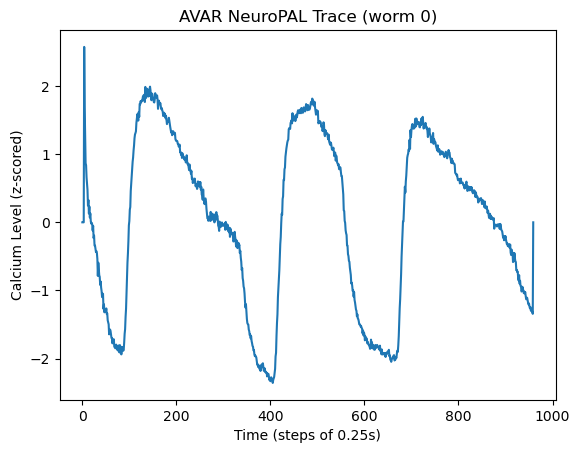

In [13]:
worm = 0
print(worm_labels[worm])
label = 'AVAR'
index = TRACE_OBJ_TABLE[f"npl-worm-{worm}"].get_index(label)
plot_trace(TRACE_OBJ_TABLE[f"npl-worm-{worm}"].traces[index,:], f"{label} NeuroPAL Trace (worm {worm})", avg_timestep=TRACE_OBJ_TABLE["npl-worm-0"].avg_timestep)

### Context

In [14]:
class Context:
    def __init__(self, trace_obj, connectome=CONNECTOME) -> None:
        self.connectome = connectome
        self.trace_obj = trace_obj

    def get_relevant_neurons(self, neuron):
        return self.connectome.get_relevant_neurons(neuron)

    def get_relevant_mask(self, neuron):
        relevant_neurons = self.get_relevant_neurons(neuron)
        return np.array([self.trace_obj.get_label(i) in relevant_neurons for i in range(self.trace_obj.num_neurons)])

    def get_relevant_mask_labels(self, neuron):
        relevant_neurons = self.get_relevant_neurons(neuron)
        indices = []
        for i in range(self.trace_obj.num_neurons):
            label = self.trace_obj.get_label(i)
            if label in relevant_neurons:
                indices.append(label)
        return indices
    
    def get_connected_component(self, neuron):
        # Only the connected neurons found in this trace_obj
        pre = set()
        s = set(self.get_relevant_mask_labels(neuron))
        diff = s - pre 
        while len(diff) != 0:
            pre = s.copy()
            for new_neuron in diff:
                adj = self.get_relevant_mask_labels(new_neuron)
                s.update(adj)
            diff = s - pre
        return s
    
    def predict(self, neurons, start=None, duration=None, plot=True):
        if not pd.api.types.is_list_like(neurons):
            neurons = [neurons]
        max_retention = max([max(neuron.w_rr, neuron.w_sr) for neuron in neurons])
        trace_len = self.trace_obj.traces.shape[1]
        if start is None or start < max_retention:
            start = max_retention
        if duration is None:
            duration = trace_len - start
        
        neuron_indices = [neuron.index for neuron in neurons]
        
        # temp_traces = np.copy(self.trace_obj.traces[:,start-max_retention:start]) # we will overwrite the self_index row with our predicted values
        # temp_traces = np.pad(temp_traces, [(0,0),(start-max_retention, duration)], mode='constant', constant_values=0)
        
        temp_traces = np.copy(self.trace_obj.traces)
        temp_traces[:,:start-max_retention] = 0
        temp_traces[neuron_indices,start:] = 0
        if start + duration > trace_len:
            temp_traces = np.pad(temp_traces, [(0,0),(0, start + duration - trace_len)], mode='constant', constant_values=0)
        # plot_trace(temp_traces[0,:])
        # plot_trace(temp_traces[neuron_indices[0],:])
        # print(len(temp_traces), start, duration, trace_len)

        for neuron in neurons:
            neuron.adapt_to_context(self)
        for t in range(start,start+duration):
            for neuron in neurons:
                neuron.predict(temp_traces, t)

        observation = self.trace_obj.traces[neuron_indices,start:start+duration]
        prediction = temp_traces[neuron_indices,start:start+duration]
        prediction = np.nan_to_num(prediction) #TODO: actually handle numerical issues

        if observation.shape == prediction.shape:
            explained_variance = 1 - (mean_squared_error(observation, prediction))/np.var(observation)
        else:
            explained_variance = np.nan
            observation = np.pad(observation, [(0,0),(0, start + duration - trace_len)], mode='constant', constant_values=0)
        
        if plot:
            if plot != 2:
                for i, neuron in enumerate(neurons):
                    DataFrame({ 
                        'Residuals': observation[i,:] - prediction[i,:],
                        'Prediction': prediction[i,:],
                        'Ground Truth': observation[i,:],
                    }).plot(
                        title=f"{neuron.label} Calcium Trace Prediction ({self.trace_obj.uid})", 
                        xlabel=f"Time (steps of {self.trace_obj.avg_timestep}s)", 
                        ylabel="Calcium Level (z-scored)",
                        legend=True)

            print(f"(predicting {self.trace_obj.uid}, start={start}, duration={duration}) Explained Variance: {explained_variance}")
            
            all_err_vect_norm_over_time = np.sqrt(np.sum(np.square(prediction - observation), axis=0))
            DataFrame(all_err_vect_norm_over_time).plot(
                title=f"Error Vector Norm Over Time ({self.trace_obj.uid})", 
                xlabel=f"Time (steps of {self.trace_obj.avg_timestep}s)",
                ylabel="Norm of Error Vector",
                logy=True,
                legend=False)

        return explained_variance, temp_traces

#### Initializing Contexts

In [15]:
FAKE_CONTEXT = Context(FAKE_TRACE_OBJ, FAKE_CONNECTOME)
CONTEXT_1 = Context(TRACE_OBJ_1, CONNECTOME)
CONTEXT_2 = Context(TRACE_OBJ_2, CONNECTOME)

CONTEXT_TABLE = {trace_obj.uid:Context(trace_obj, CONNECTOME) for trace_obj in TRACE_OBJ_TABLE.values()}

### Neuron

In [16]:
class Neuron:
    def __init__(self, label, w_rr=None, w_sr=None, context=None, c=None):
        self.label = label
        self.w_rr = w_rr
        self.w_sr = w_sr

        self._set_c(c)
        self._set_context(context)

    def _set_c(self, c):
        self.c = c
        self.C = (None if (self.c is None or self.w_rr is None or self.w_sr is None) 
                        else self.c.reshape((self.relevant_count, self.w_rr, 1, self.w_sr+1)))

    def _set_context(self, context):
        if context is None:
            self.context = None
            self.relevant_mask = None
            self.relevant_count = None
            self.relevant_labels = None
            self.index = None
        elif not hasattr(self, 'context') or context != self.context:
            self.context = context
            self.relevant_mask = self.context.get_relevant_mask(self.label)
            self.relevant_count = np.count_nonzero(self.relevant_mask)
            self.relevant_labels = self.context.get_relevant_mask_labels(self.label)
            self.index = self.context.trace_obj.get_index(self.label)

    def adapt_to_context(self, new_context):
        if new_context == self.context:
            return
        
        if self.c is None:
            self._set_context(new_context)
            return

        old_relevant_labels = self.relevant_labels
        self._set_context(new_context)

        augmented_C = np.concatenate((self.C, np.zeros((1, self.w_rr, 1, self.w_sr+1))))
        perm = [(old_relevant_labels.index(label) if label in old_relevant_labels else -1) for label in self.relevant_labels]
        self.C = augmented_C[perm,:,:,:]
        self.c = self.C.reshape(self.relevant_count*self.w_rr*(self.w_sr+1))

    def optimize(
            self, w_rr_search_space, w_sr_search_space, 
            train_context, train_window_start=0, train_window_width=None,
            test_context=None,  test_window_start=0, test_window_width=None,
            plot=True
    ):
        if isinstance(w_rr_search_space, int):
            w_rr_search_space = range(1,w_rr_search_space)
        if isinstance(w_sr_search_space, int):
            w_sr_search_space = range(w_sr_search_space)

        if test_context is None:
            test_context = train_context
            test_window_start = train_window_start + train_window_width # test on rest of training data

        max_explained_variance = -np.inf
        opt_w_rr, opt_w_sr = -1,-1
        for w_rr in w_rr_search_space:
            for w_sr in w_sr_search_space:
                self.fit(w_rr=w_rr, w_sr=w_sr, context=train_context, window_start=train_window_start, window_width=train_window_width, plot=False)
                explained_variance, _ = self.context.predict(self, start=test_window_start, duration=test_window_width, plot=False)
                if explained_variance > max_explained_variance:
                    max_explained_variance = explained_variance
                    opt_w_rr, opt_w_sr = w_rr, w_sr
        self.fit(w_rr=opt_w_rr, w_sr=opt_w_sr, window_start=train_window_start, window_width=train_window_width, plot=plot)

    def fit(self, w_rr=None, w_sr=None, window_start=0, window_width=None, context=None, plot=True):
        if w_rr is not None:
            self.w_rr = w_rr
        if w_sr is not None:
            self.w_sr = w_sr
        if context is not None:
            self._set_context(context)

        if window_width is None:
            window_width = self.context.trace_obj.traces.shape[1] - window_start
        num_windows = window_width - max(self.w_rr,self.w_sr) + 1

        traces = self.context.trace_obj.traces[:,window_start : window_start + window_width]
        
        if self.index == -1:
            raise ValueError(f"Neuron {self.label} does not have any labeled traces in this dataset.")

        # TODO: We incur a T x relevant_count x w_rr x 1 x (w_sr+1) (about 3000x) blowup here - there is a LOT of redundancy that might be used to bring this down.
        # relevant_count x w_rr x 1 x (w_sr+1) (about 3000) is the number of entries in C
        relevant_sliding_window = np.squeeze(sliding_window_view(traces[self.relevant_mask, max(self.w_sr-self.w_rr,0):], (self.relevant_count, self.w_rr), writeable=False), axis=0)
        self_sliding_window = np.squeeze(sliding_window_view(traces[self.index:self.index+1,max(self.w_rr-self.w_sr,0):], (1, self.w_sr), writeable=False), axis=0)
        self_sliding_window = np.concatenate((self_sliding_window, np.ones((num_windows, 1, 1))), axis=2)
        A = contract("tij,tkl->tijkl", relevant_sliding_window, self_sliding_window).reshape(num_windows, self.relevant_count * self.w_rr * (self.w_sr + 1))
        A = A[:-1,:] # can't predict outside of observation window

        # Looking to minimize Ac - traces[neuron]
        observation = traces[self.index][max(self.w_rr,self.w_sr):]
        c, residuals, rank, singular_values = np.linalg.lstsq(A, observation, rcond=-1) # Formula: np.linalg.inv(A.T @ A) @ A.T @ observation
        self._set_c(c)

        prediction = A @ self.c
        explained_variance = 1 - (mean_squared_error(observation, prediction))/np.var(observation)

        if plot:
            # plot_trace(observation, title=f"{neuron} Calcium Trace ({trace_obj.uid})", avg_timestep=self.trace_obj.avg_timestep)
            # plot_trace(prediction, title=f"Model Fit for {neuron} Trace ({trace_obj.uid})", avg_timestep=self.trace_obj.avg_timestep)
            # plot_trace(residuals,  title="Training Residuals", ylabel="Residual", avg_timestep=self.trace_obj.avg_timestep)
            print(f"({self.label} fit, w_rr={self.w_rr}, w_sr={self.w_sr}, trace={self.context.trace_obj.uid}) Explained Variance: {explained_variance}")

        return explained_variance

    def predict(self, traces, t):
        relevant_history = traces[self.relevant_mask, t-self.w_rr:t]
        self_history = traces[self.index:self.index+1, t-self.w_sr:t]
        augmented_self_history = np.concatenate((self_history, np.ones((1,1))), axis=1)
        traces[self.index, t] = contract("ij,ijkl,kl", relevant_history, self.C, augmented_self_history)

    def plot_neighbors(self):
        figure, ax = plt.subplots(1, 2)

        in_weights = np.array([[self.context.connectome.get_weight(neighbor, self.label) for neighbor in self.relevant_labels]]).T
        im, cbar = heatmap(in_weights, self.relevant_labels, [f'{self.label} (in)'], ax[0], cmap=plt.cm.Reds, cbarlabel='Connection Strength')
        texts = annotate_heatmap(im, valfmt='{x}', size=7)

        out_weights = np.array([[self.context.connectome.get_weight(self.label, neighbor) for neighbor in self.relevant_labels]]).T
        im, cbar = heatmap(out_weights, self.relevant_labels, [f'{self.label} (out)'], ax[0], cmap=plt.cm.Blues, cbarlabel='Connection Strength')
        texts = annotate_heatmap(im, valfmt='{x}', size=7)

        figure.show()

    def visualize_c(self, fig=None):
        if self.label in self.relevant_labels:
            i = self.relevant_labels.index(self.label)
            self.relevant_labels[i] = f'$\\bf{{{self.relevant_labels[i]}}}$'

        biggest = max(abs(np.max(self.C)), abs(np.min(self.C)))
        norm = matplotlib.colors.Normalize(vmin=-biggest, vmax=biggest)

        if fig is None:
            fig = plt.figure()

        grid = AxesGrid(fig, 111,
                        nrows_ncols=(1, self.w_sr+1),
                        axes_pad=0.05,
                        cbar_mode='single',
                        cbar_location='right',
                        cbar_pad=0.1,
                        cbar_size="15%"
                        )

        for i,ax in enumerate(grid):
            im = ax.imshow(self.C[:,:,0,i], cmap=plt.cm.coolwarm, norm=norm)
            ax.set_yticks(np.arange(self.relevant_count), self.relevant_labels)
            ax.set_xticks(np.arange(self.w_rr), np.arange(self.w_rr,0,-1))
        cbar = ax.cax.colorbar(im)

        plt.show()

## Mini Tests

In [17]:
s = CONTEXT_1.get_connected_component('AVAL')
print(len(s))

94


In [18]:
print(sorted(((d,n) for n,d in CONNECTOME.degree), reverse=True))

[(229, 'AVAL'), (222, 'AVAR'), (202, 'hyp'), (163, 'AVG'), (161, 'PVV'), (156, 'PVZ'), (156, 'EF2'), (154, 'AVBR'), (152, 'PDB'), (143, 'PVX'), (136, 'PVNL'), (132, 'EF3'), (132, 'CA05'), (127, 'PVCR'), (126, 'AVBL'), (122, 'EF1'), (119, 'R7BL'), (119, 'DVA'), (114, 'HOB'), (112, 'HOA'), (111, 'SPVR'), (108, 'DVC'), (107, 'VA12'), (106, 'PQR'), (105, 'VB09'), (103, 'PVNR'), (103, 'CA06'), (102, 'CP04'), (101, 'AVFL'), (100, 'PVCL'), (99, 'VB08'), (99, 'SPVL'), (99, 'R1BR'), (98, 'PVPL'), (97, 'CP05'), (96, 'VB10'), (95, 'R7AR'), (94, 'PVY'), (94, 'DVF'), (94, 'CP09'), (94, 'CP07'), (94, 'AVKR'), (94, 'AVKL'), (89, 'DD05'), (86, 'R7BR'), (86, 'R3BR'), (85, 'R2BL'), (83, 'VA10'), (82, 'PVQR'), (81, 'R2BR'), (81, 'AVFR'), (80, 'PHCL'), (80, 'CP06'), (78, 'R7AL'), (77, 'PCBL'), (77, 'DD06'), (77, 'AVDR'), (76, 'PDC'), (74, 'R2AL'), (74, 'PHCR'), (74, 'AVL'), (73, 'VD10'), (73, 'VB06'), (73, 'PCAL'), (72, 'VD09'), (72, 'PCBR'), (71, 'RIBR'), (71, 'AVDL'), (70, 'R5BR'), (70, 'R3BL'), (70, 'P

In [19]:
# nx.draw_networkx(CONNECTOME, arrows=True)

## Tests

### Fake Tests

(N1 fit, w_rr=24, w_sr=1, trace=www_fake data) Explained Variance: 1.0


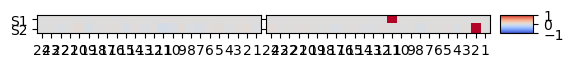

(predicting www_fake data, start=1000, duration=600) Explained Variance: 1.0


(1.0,
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.38735397e+00,  4.34030957e-01,  7.60525819e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.74172328e-15,  7.81831482e-02,  9.74927912e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]))

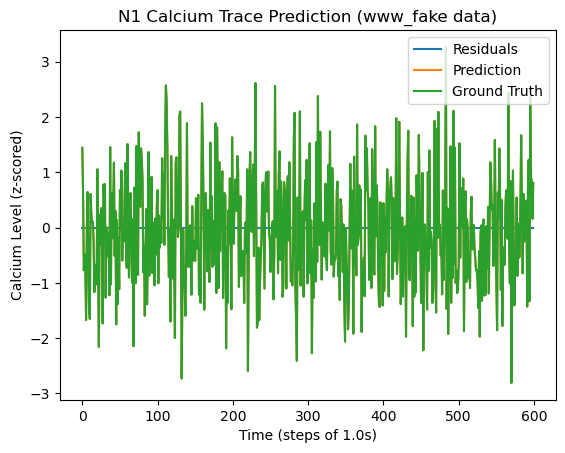

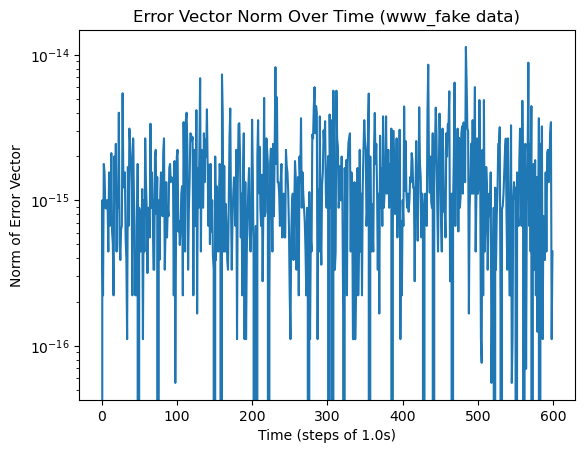

In [41]:
fake_trace_obj = TraceObject.from_www_json('datasets/fake_test_data/fake_traces.json')
fake_w_rr = 12
fake_w_sr = 0

N1 = Neuron('N1', w_rr=24, w_sr=1)
N1.fit(window_start=0, window_width=800, context=FAKE_CONTEXT, plot=True)
N1.visualize_c()
FAKE_CONTEXT.predict(N1, start=1000, duration=600, plot=True)

### Real Tests

#### AVAR fit

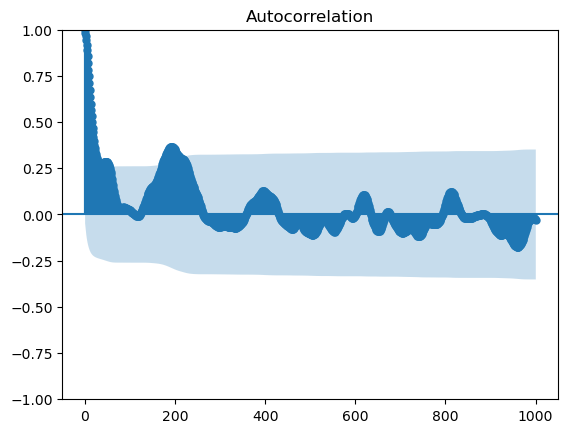

(AVAR fit, w_rr=3, w_sr=1, trace=www_2022-08-02-01) Explained Variance: 0.9804599687458282
(predicting www_2022-08-02-01, start=730, duration=870) Explained Variance: 0.916205068903548
96
[-3.12736006e-02 -2.37579685e-02  1.20131855e-03 -9.41505174e-03
  2.09976899e-02  9.02825654e-03 -2.37242093e-02 -1.04878091e-02
 -2.13267912e-02 -8.82726775e-03 -3.48118148e-03 -9.54847784e-03
 -2.93319985e-02 -4.95748010e-03 -5.00671843e-03  1.92728989e-03
  5.73353741e-04 -2.89308866e-02  3.87660164e-02 -5.82224922e-02
 -3.89495712e-03  4.31857393e-03 -1.25257407e-02  2.54340584e-02
  2.74521774e-02  1.64295689e-02 -7.93418801e-02  9.18753384e-04
 -2.67132922e-02  3.83477250e-01 -2.97592040e-03  1.37476782e-02
  1.82053113e-02  2.59629042e-02  5.77640633e-02  2.44947185e-02
 -6.90480250e-02 -1.66220266e-01  3.31454409e-02  1.20556423e-01
  6.89284060e-03  5.81134938e-01  6.99248982e-03  6.79405919e-03
  8.60998674e-03 -9.98534944e-05  2.12593657e-02  2.59416280e-02
  1.98048764e-02 -9.85350970e-03

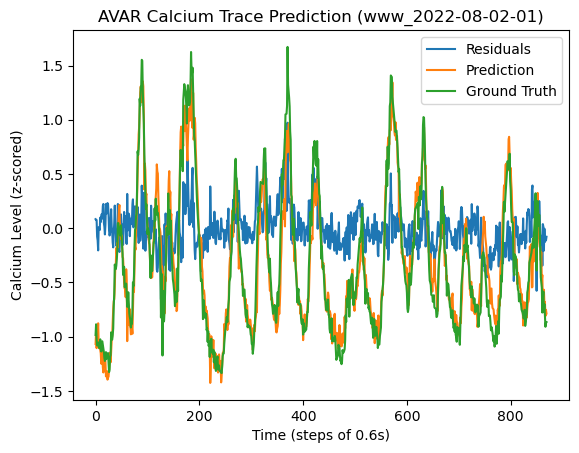

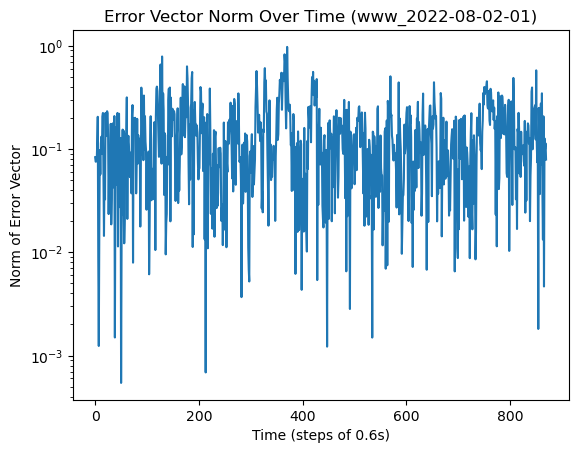

In [20]:
TEST_NEURON = Neuron('AVAR')

self_index = CONTEXT_1.trace_obj.get_index(TEST_NEURON.label)
if self_index == -1:
    raise ValueError(f"Neuron {TEST_NEURON} does not have any labeled traces in this dataset.")

plot_acf(CONTEXT_1.trace_obj.traces[self_index,:], lags=1000)
plt.show()

TEST_NEURON.fit(w_rr=3, w_sr=1, window_start=0, window_width=730, context=CONTEXT_1, plot=True)
CONTEXT_1.predict(TEST_NEURON, start=730)

print(len(TEST_NEURON.c))
print(TEST_NEURON.c)

#### visualize_c

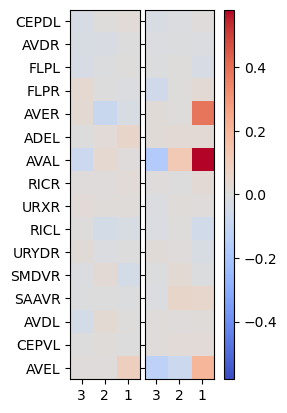

In [89]:
TEST_NEURON.visualize_c()

#### Adapting C to new dataset

(AVAR fit, w_rr=3, w_sr=1, trace=www_2022-08-02-01) Explained Variance: 0.9700132376404147


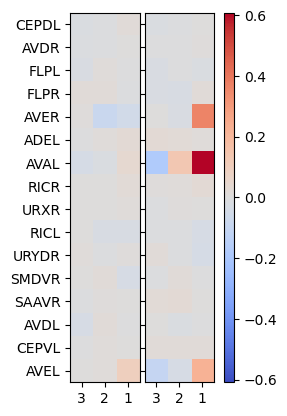

In [43]:
TEST_NEURON = Neuron("AVAR", 3, 1, CONTEXT_1)
TEST_NEURON.fit()
TEST_NEURON.visualize_c()


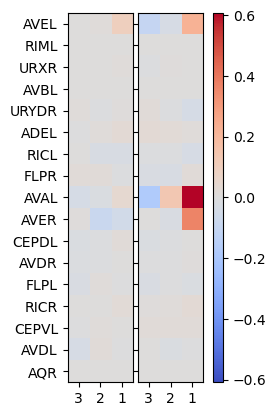

In [24]:
TEST_NEURON.adapt_to_context(CONTEXT_2)
TEST_NEURON.visualize_c()

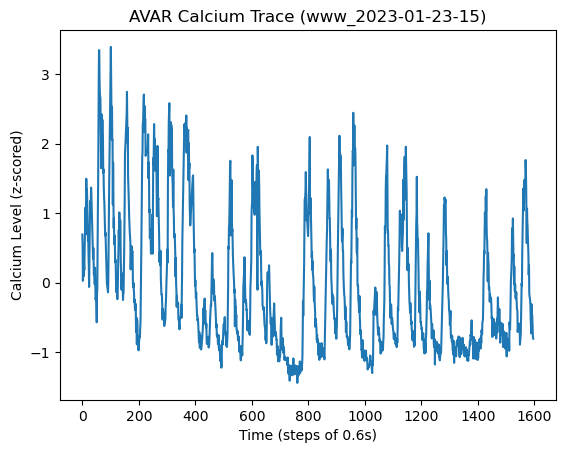

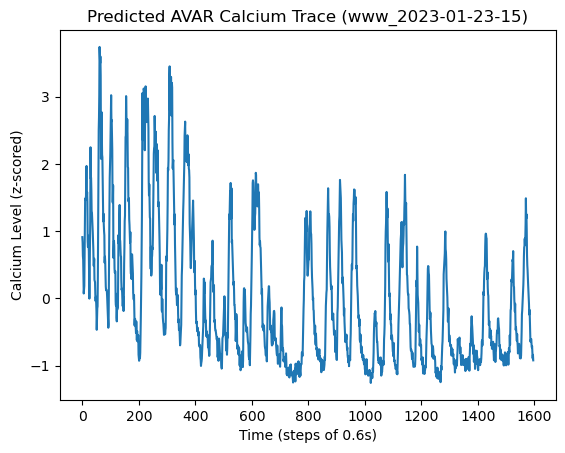

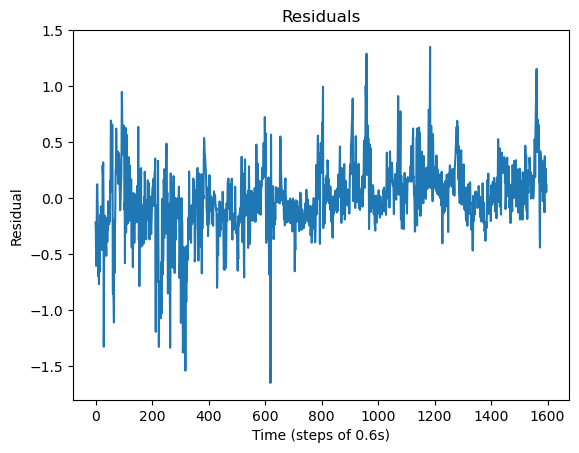

(predicting www_2023-01-23-15, start=3, duration=1597) Explained Variance: 0.8997770219568312


0.8997770219568312

In [25]:
CONTEXT_2.predict(TEST_NEURON)

#### Automating w_rr and w_sr finding

In [20]:
with open('testtrace.pickle', 'rb') as infile:
    uid = pickle.load(infile)
    avg_timestep = pickle.load(infile)
    traces = pickle.load(infile)
    labels = pickle.load(infile)
INDEP_TRACE_OBJ = TraceObject(uid, avg_timestep, traces, labels)
INDEP_CONTEXT = Context(INDEP_TRACE_OBJ, CONNECTOME)

In [21]:
raw_neuron_labels = list(INDEP_CONTEXT.trace_obj._label_to_index_map.keys()) # ['AVAR', 'AVAL', 'AVER', 'AVEL']
neuron_labels = []
for label in raw_neuron_labels:
    if INDEP_CONTEXT.connectome.has_node(label):
        neuron_labels.append(label)
    else:
        print(f"Problematic neuron label found in dataset {INDEP_CONTEXT.trace_obj.uid}: {label}.")
print(len(neuron_labels), 'good neuron labels:', neuron_labels)

neurons = [Neuron(label) for label in neuron_labels]
for neuron in neurons:
    print(f'Optimizing {neuron.label}')
    neuron.optimize(20, 3, train_context=INDEP_CONTEXT, train_window_start=0, train_window_width=700, plot=False)
    print(f"{neuron.label}: w_rr={neuron.w_rr}, w_sr={neuron.w_sr}")
    # neuron.visualize_c()


Problematic neuron label found in dataset www_2023-01-23-21: AIM?.
Problematic neuron label found in dataset www_2023-01-23-21: SMBV?.
Problematic neuron label found in dataset www_2023-01-23-21: RMF?.
Problematic neuron label found in dataset www_2023-01-23-21: IL1V?.
95 good neuron labels: ['AVEL', 'RMEL', 'AWAR', 'URYDL', 'I2L', 'SAAVL', 'I1R', 'RMDR', 'IL1DL', 'URYDR', 'SIBVL', 'RMER', 'SMDVR', 'RIAR', 'SAADL', 'M3R', 'RICR', 'ADAL', 'RMDVR', 'AIBL', 'OLQVL', 'RMEV', 'OLLL', 'RMDL', 'RMDDL', 'NSMR', 'AIZL', 'AVDR', 'URXR', 'AIZR', 'AVAL', 'IL2DL', 'RID', 'AQR', 'CEPDL', 'AVAR', 'RIBL', 'I2R', 'AVDL', 'AVJR', 'IL2L', 'NSML', 'AINR', 'RIMR', 'M4', 'AIYR', 'CEPVL', 'IL2R', 'AWCR', 'AWBR', 'OLQDR', 'IL1L', 'URYVR', 'MCR', 'AUAL', 'AWAL', 'RMDVL', 'RMGL', 'M3L', 'IL2VL', 'FLPL', 'AVER', 'RIVR', 'I3', 'AIBR', 'RMDDR', 'I1L', 'URXL', 'CEPVR', 'IL1DR', 'OLQDL', 'IL2VR', 'RMED', 'URBL', 'ASGL', 'ASHL', 'M5', 'AVJL', 'SMDVL', 'OLLR', 'RIVL', 'IL1R', 'MI', 'ADEL', 'URYVL', 'AWCL', 'AINL', 'MC

AVEL: w_rr=4, w_sr=0
Optimizing RMEL


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

RMEL: w_rr=2, w_sr=0
Optimizing AWAR
AWAR: w_rr=16, w_sr=1
Optimizing URYDL
URYDL: w_rr=1, w_sr=0
Optimizing I2L
I2L: w_rr=2, w_sr=0
Optimizing SAAVL
SAAVL: w_rr=1, w_sr=0
Optimizing I1R
I1R: w_rr=4, w_sr=0
Optimizing RMDR
RMDR: w_rr=1, w_sr=0
Optimizing IL1DL
IL1DL: w_rr=2, w_sr=1
Optimizing URYDR
URYDR: w_rr=4, w_sr=0
Optimizing SIBVL
SIBVL: w_rr=5, w_sr=2
Optimizing RMER


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

RMER: w_rr=1, w_sr=0
Optimizing SMDVR
SMDVR: w_rr=1, w_sr=0
Optimizing RIAR


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


RIAR: w_rr=1, w_sr=0
Optimizing SAADL
SAADL: w_rr=19, w_sr=0
Optimizing M3R
M3R: w_rr=7, w_sr=1
Optimizing RICR
RICR: w_rr=11, w_sr=0
Optimizing ADAL
ADAL: w_rr=1, w_sr=2
Optimizing RMDVR
RMDVR: w_rr=6, w_sr=0
Optimizing AIBL


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

AIBL: w_rr=7, w_sr=0
Optimizing OLQVL
OLQVL: w_rr=6, w_sr=1
Optimizing RMEV
RMEV: w_rr=10, w_sr=1
Optimizing OLLL
OLLL: w_rr=2, w_sr=0
Optimizing RMDL


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

RMDL: w_rr=2, w_sr=0
Optimizing RMDDL
RMDDL: w_rr=2, w_sr=2
Optimizing NSMR
NSMR: w_rr=1, w_sr=2
Optimizing AIZL
AIZL: w_rr=2, w_sr=0
Optimizing AVDR
AVDR: w_rr=16, w_sr=0
Optimizing URXR
URXR: w_rr=10, w_sr=1
Optimizing AIZR


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

AIZR: w_rr=13, w_sr=0
Optimizing AVAL
AVAL: w_rr=5, w_sr=0
Optimizing IL2DL
IL2DL: w_rr=14, w_sr=1
Optimizing RID
RID: w_rr=9, w_sr=0
Optimizing AQR
AQR: w_rr=6, w_sr=0
Optimizing CEPDL
CEPDL: w_rr=1, w_sr=1
Optimizing AVAR
AVAR: w_rr=1, w_sr=0
Optimizing RIBL
RIBL: w_rr=14, w_sr=0
Optimizing I2R
I2R: w_rr=3, w_sr=0
Optimizing AVDL
AVDL: w_rr=8, w_sr=2
Optimizing AVJR
AVJR: w_rr=2, w_sr=1
Optimizing IL2L
IL2L: w_rr=4, w_sr=1
Optimizing NSML
NSML: w_rr=6, w_sr=1
Optimizing AINR
AINR: w_rr=4, w_sr=2
Optimizing RIMR
RIMR: w_rr=2, w_sr=2
Optimizing M4


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

M4: w_rr=5, w_sr=0
Optimizing AIYR
AIYR: w_rr=2, w_sr=0
Optimizing CEPVL


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

CEPVL: w_rr=1, w_sr=0
Optimizing IL2R
IL2R: w_rr=1, w_sr=1
Optimizing AWCR
AWCR: w_rr=3, w_sr=2
Optimizing AWBR
AWBR: w_rr=7, w_sr=1
Optimizing OLQDR
OLQDR: w_rr=3, w_sr=0
Optimizing IL1L
IL1L: w_rr=17, w_sr=0
Optimizing URYVR
URYVR: w_rr=1, w_sr=0
Optimizing MCR
MCR: w_rr=4, w_sr=0
Optimizing AUAL
AUAL: w_rr=1, w_sr=2
Optimizing AWAL
AWAL: w_rr=3, w_sr=1
Optimizing RMDVL
RMDVL: w_rr=14, w_sr=0
Optimizing RMGL


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

RMGL: w_rr=11, w_sr=0
Optimizing M3L
M3L: w_rr=10, w_sr=0
Optimizing IL2VL
IL2VL: w_rr=8, w_sr=2
Optimizing FLPL
FLPL: w_rr=2, w_sr=2
Optimizing AVER
AVER: w_rr=4, w_sr=0
Optimizing RIVR


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

RIVR: w_rr=1, w_sr=1
Optimizing I3
I3: w_rr=8, w_sr=1
Optimizing AIBR
AIBR: w_rr=1, w_sr=0
Optimizing RMDDR
RMDDR: w_rr=1, w_sr=0
Optimizing I1L
I1L: w_rr=3, w_sr=0
Optimizing URXL
URXL: w_rr=16, w_sr=0
Optimizing CEPVR
CEPVR: w_rr=3, w_sr=1
Optimizing IL1DR
IL1DR: w_rr=7, w_sr=1
Optimizing OLQDL


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

OLQDL: w_rr=3, w_sr=2
Optimizing IL2VR
IL2VR: w_rr=2, w_sr=0
Optimizing RMED
RMED: w_rr=3, w_sr=1
Optimizing URBL
URBL: w_rr=1, w_sr=1
Optimizing ASGL
ASGL: w_rr=2, w_sr=0
Optimizing ASHL
ASHL: w_rr=4, w_sr=1
Optimizing M5


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

M5: w_rr=5, w_sr=1
Optimizing AVJL
AVJL: w_rr=14, w_sr=0
Optimizing SMDVL


/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

SMDVL: w_rr=4, w_sr=0
Optimizing OLLR
OLLR: w_rr=2, w_sr=0
Optimizing RIVL
RIVL: w_rr=2, w_sr=1
Optimizing IL1R
IL1R: w_rr=4, w_sr=0
Optimizing MI
MI: w_rr=1, w_sr=0
Optimizing ADEL
ADEL: w_rr=19, w_sr=0
Optimizing URYVL
URYVL: w_rr=13, w_sr=0
Optimizing AWCL
AWCL: w_rr=2, w_sr=1
Optimizing AINL
AINL: w_rr=19, w_sr=0
Optimizing MCL
MCL: w_rr=5, w_sr=0
Optimizing AIYL
AIYL: w_rr=19, w_sr=0
Optimizing AVHL
AVHL: w_rr=1, w_sr=0
Optimizing ASGR
ASGR: w_rr=4, w_sr=0
Optimizing CEPDR
CEPDR: w_rr=2, w_sr=0
Optimizing M1
M1: w_rr=7, w_sr=0
Optimizing RICL
RICL: w_rr=1, w_sr=1
Optimizing URBR
URBR: w_rr=18, w_sr=0


In [23]:
COMPLETE_INDEP_TRACE_OBJ = TraceObject.from_www_json("datasets/wormwideweb/2023-01-23-21.json")
COMPLETE_INDEP_CONTEXT = Context(COMPLETE_INDEP_TRACE_OBJ, CONNECTOME)

/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/tmp/ipykernel_1741751/34164389.py:90: RuntimeWarning: overflow encountered in square
  all_err_vect_norm_over_time = np.sqrt(np.sum(np.square(prediction - observation), axis=0))


(predicting www_2023-01-23-21, start=19, duration=1581) Explained Variance: -inf


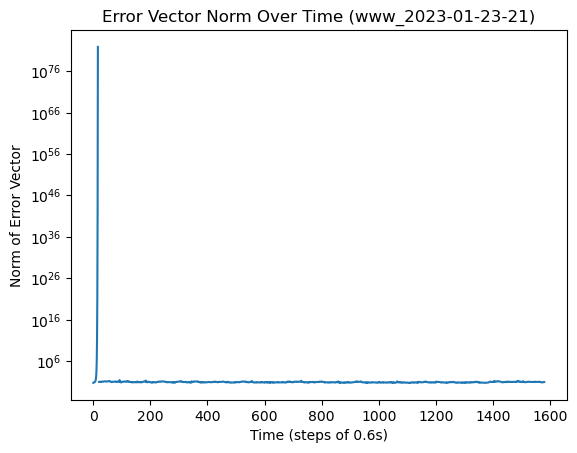

In [28]:
overall_explained_variance, predictions = COMPLETE_INDEP_CONTEXT.predict(neurons, start=0, duration=None, plot=2)

##### Plot one neuron at random

RIAR Explained Variance: -0.0003512044351365873


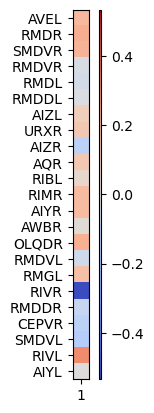

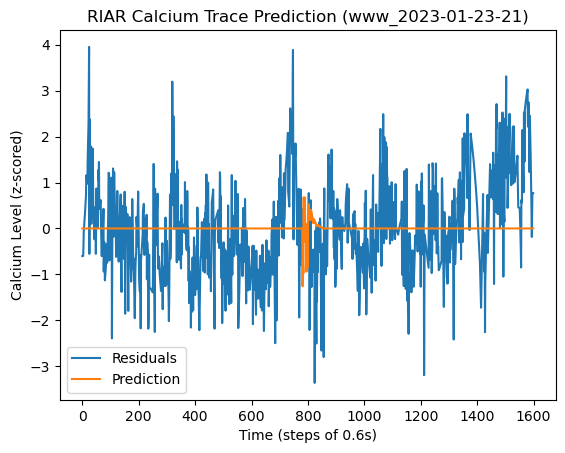

In [27]:
neuron = neurons[np.random.randint(len(neurons))]
i = neuron.index
prediction = predictions[i,:]
observation = COMPLETE_INDEP_TRACE_OBJ.traces[i,:]
if len(observation) != len(prediction):
    observation = np.pad(observation, [(0,len(prediction)-len(observation))], mode='constant', constant_values=0)
explained_variance = 1 - (mean_squared_error(observation, prediction))/np.var(observation)
print(f"{neuron.label} Explained Variance: {explained_variance}")

neuron.visualize_c()

DataFrame({ 
    'Residuals': (observation - prediction),
    'Prediction': prediction,
    # 'Ground Truth': observation,
}).plot(
    title=f"{neuron.label} Calcium Trace Prediction ({INDEP_CONTEXT.trace_obj.uid})", 
    xlabel=f"Time (steps of {INDEP_CONTEXT.trace_obj.avg_timestep}s)", 
    ylabel="Calcium Level (z-scored)",
    legend=True)
plt.show()

##### Histogram of Explained Variances

95


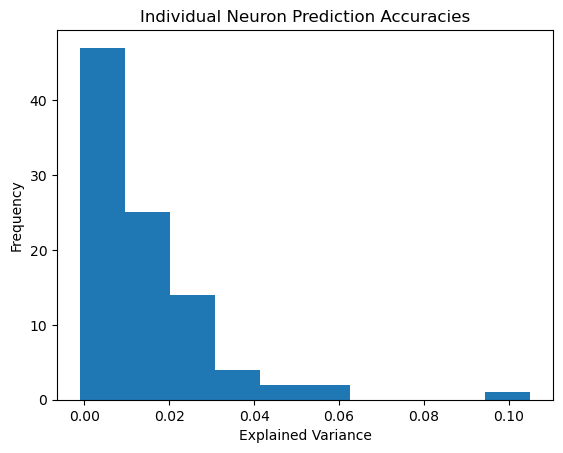

In [79]:
print(len(neurons))

evs = []
for i in range(len(neurons)):
    prediction = predictions[neurons[i].index,:]
    observation = COMPLETE_INDEP_TRACE_OBJ.traces[neurons[i].index,:]
    if len(observation) != len(prediction):
        observation = np.pad(observation, [(0,len(prediction)-len(observation))], mode='constant', constant_values=0)
    explained_variance = 1 - (mean_squared_error(observation, prediction))/np.var(observation)
    evs.append(explained_variance)

DataFrame(evs).plot(kind='hist', title="Individual Neuron Prediction Accuracies", xlabel="Explained Variance", legend=False)
plt.show()

##### Save Trained Neuron Parameters to File

In [94]:
with open(f"neurons_{date.today()}.pickle", "wb") as outfile:
    pickle.dump(len(neurons), outfile)
    for neuron in neurons:
        pickle.dump(neuron, outfile)

AttributeError: Can't pickle local object 'TraceObject.__init__.<locals>.<lambda>'

In [191]:
neuron_Cs = {}
for neuron in neurons:
    neuron_Cs[neuron.label] = neuron.C
with open(f"neurons_{date.today()}-justC.pickle", "wb") as outfile:
    pickle.dump(neuron_Cs, outfile)

#### predicting trace 2

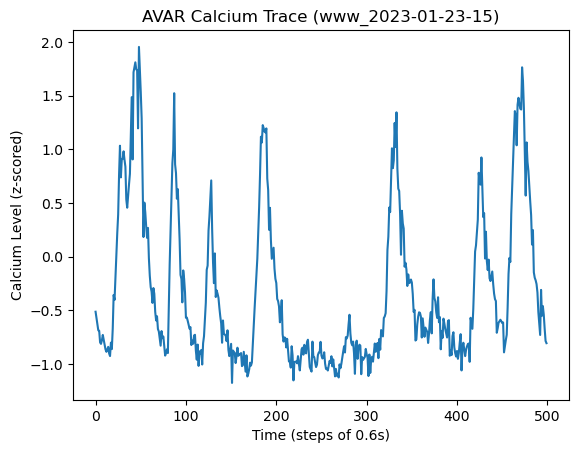

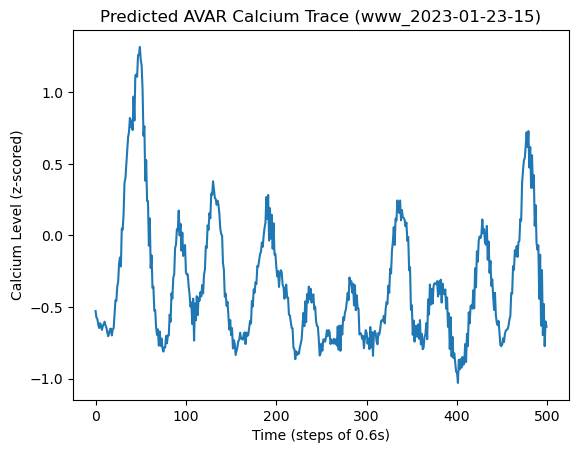

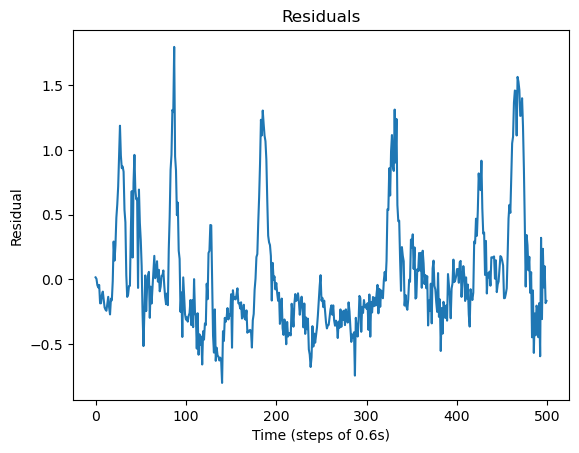

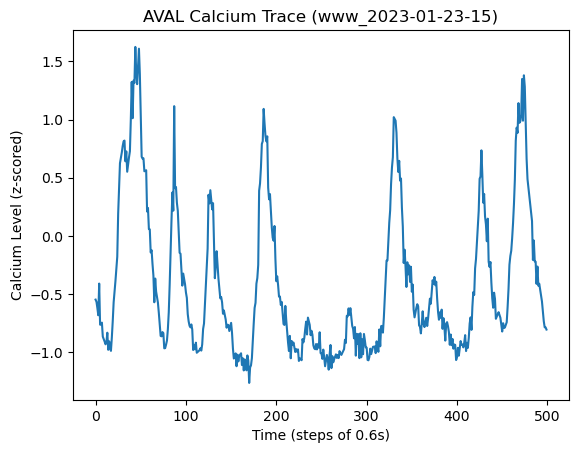

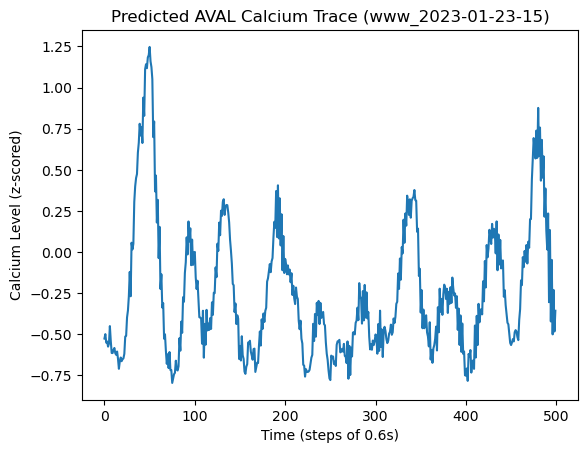

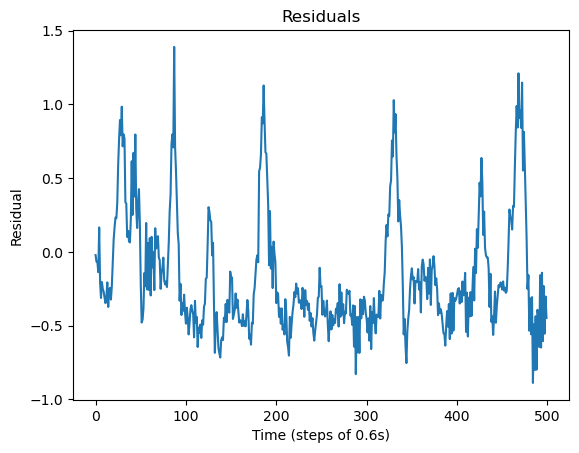

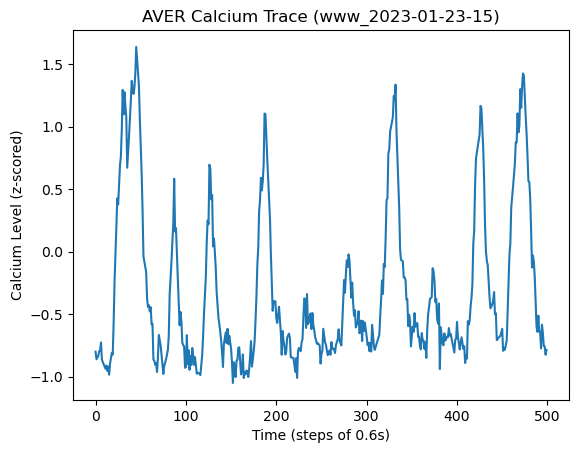

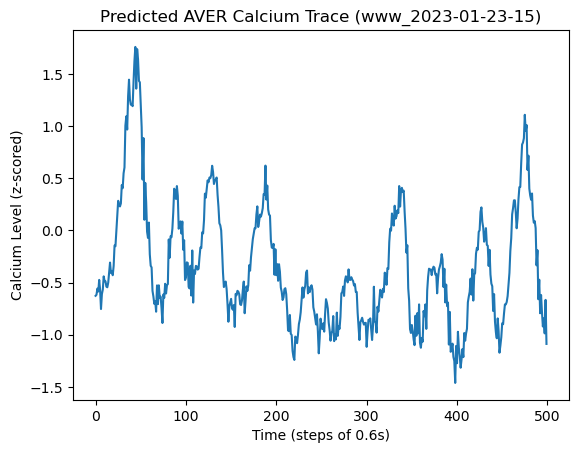

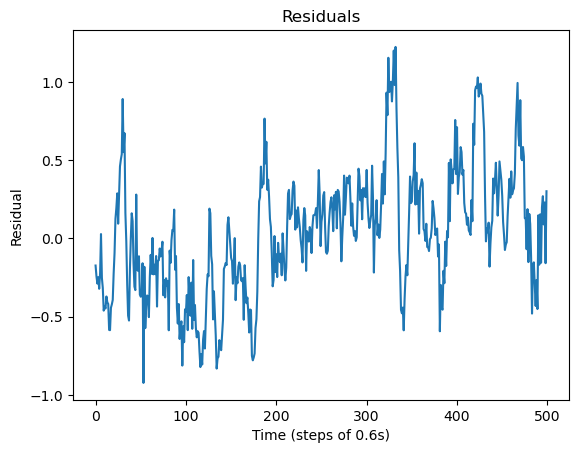

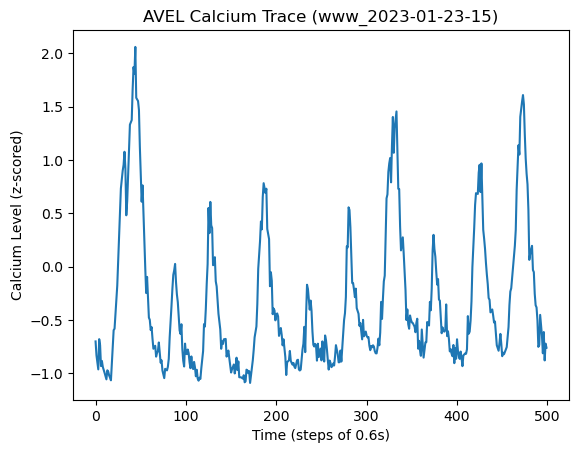

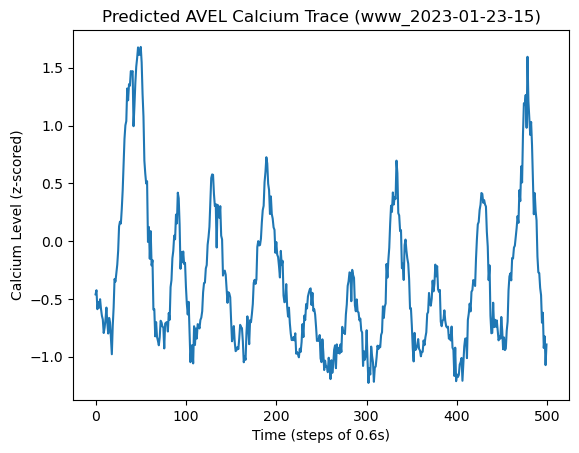

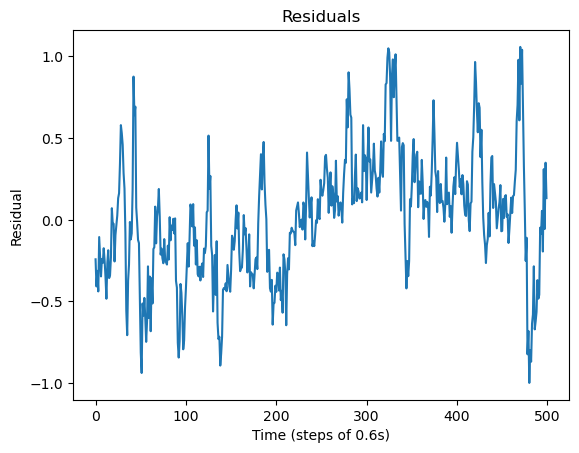

(predicting www_2023-01-23-15, start=1100, duration=500) Explained Variance: 0.6149317513155954


0.6149317513155954

In [27]:
CONTEXT_2.predict(neurons, start=1100, duration=500, plot=True)

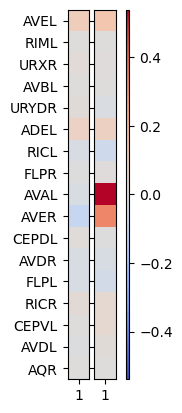

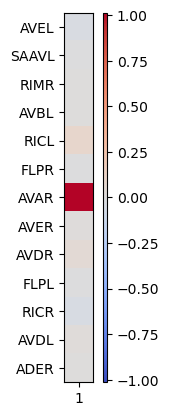

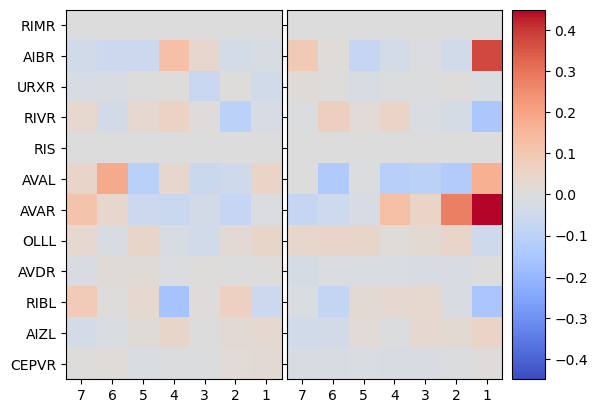

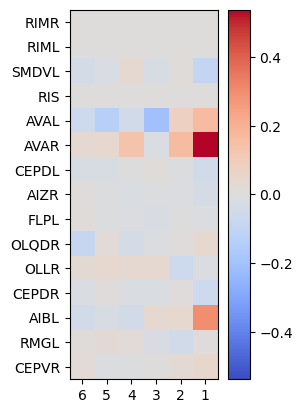

In [28]:
for neuron in neurons:
    neuron.visualize_c()

#### Predicting NeuroPAL traces

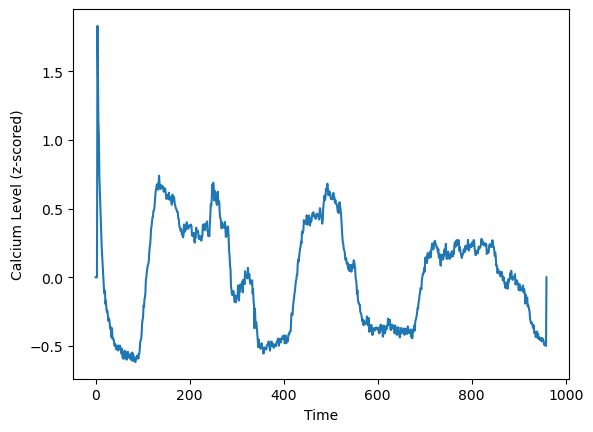

In [29]:
temp_context = CONTEXT_TABLE['npl-worm-0']
NPL_TEST_NEURON = Neuron('AVEL')

self_index = temp_context.trace_obj.get_index(NPL_TEST_NEURON.label)
if self_index == -1:
    raise ValueError(f"Neuron {NPL_TEST_NEURON.label} does not have any labeled traces in this dataset.")

plot_trace(temp_context.trace_obj.traces[self_index,:])

# plot_acf(temp_context.trace_obj.traces[self_index,:], lags=100)
# plt.show()

# NPL_TEST_NEURON.fit(w_rr=3, w_sr=1, window_start=0, window_width=730, context=temp_context, plot=True)
# temp_context.predict(NPL_TEST_NEURON, start=730)

# print(len(NPL_TEST_NEURON.c))
# print(NPL_TEST_NEURON.c)
# NPL_TEST_NEURON.visualize_c()

### ARIMA

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 274.307
Date:                Fri, 01 Mar 2024   AIC                           -536.614
Time:                        12:21:56   BIC                           -509.064
Sample:                             0   HQIC                          -525.984
                                - 730                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0397      0.028      1.444      0.149      -0.014       0.094
ar.L2          0.1629      0.038      4.269      0.000       0.088       0.238
ar.L3          0.1420      0.037      3.799      0.0

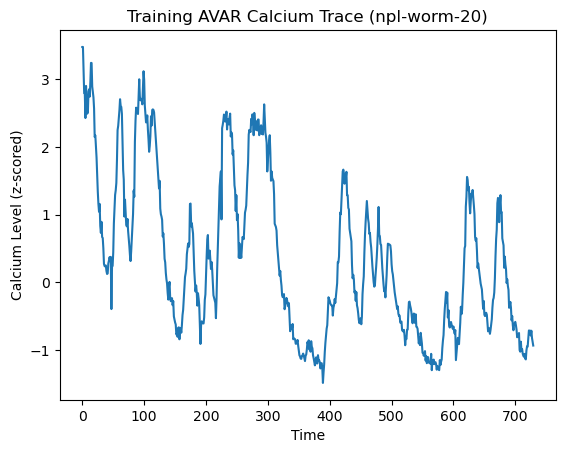

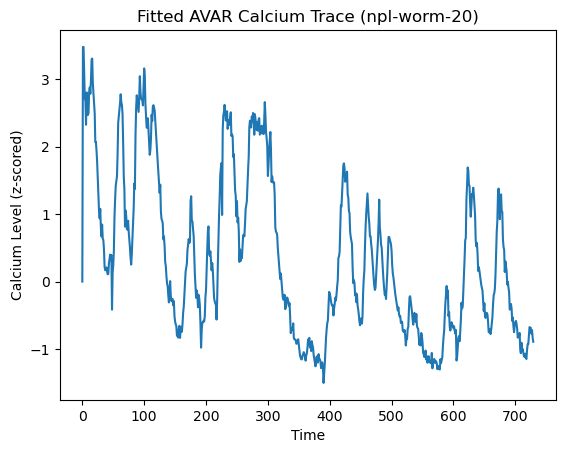

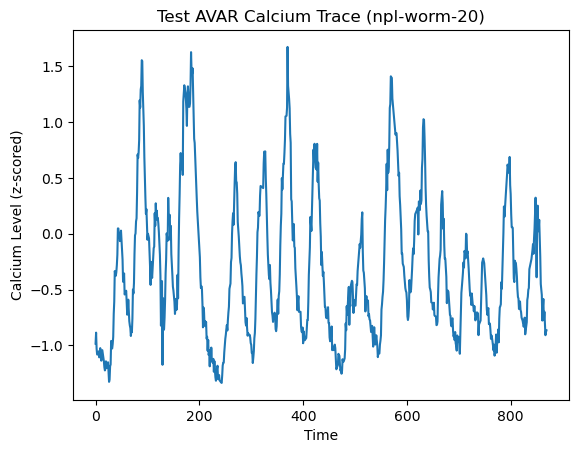

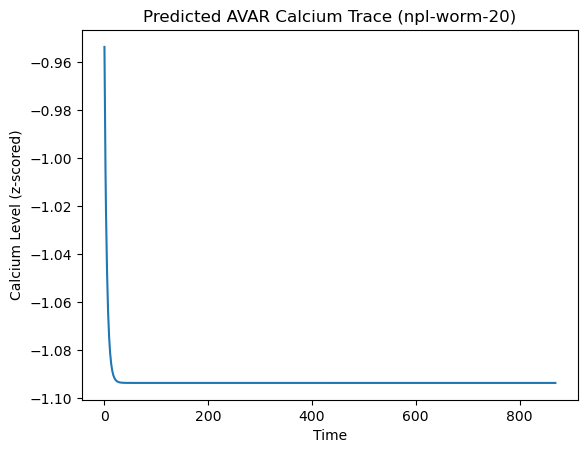

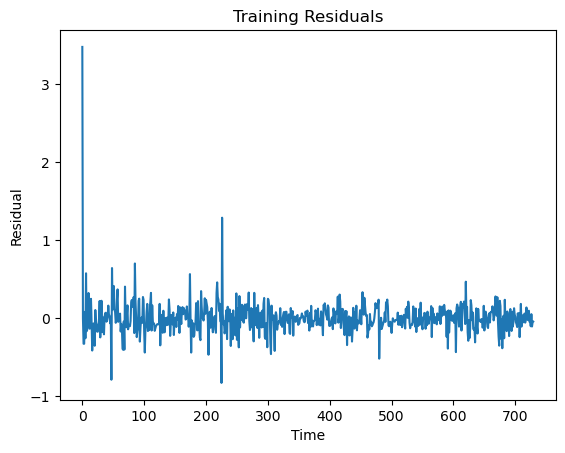

                0
count  730.000000
mean     0.001739
std      0.210123
min     -0.826684
25%     -0.088428
50%     -0.007717
75%      0.087777
max      3.474439


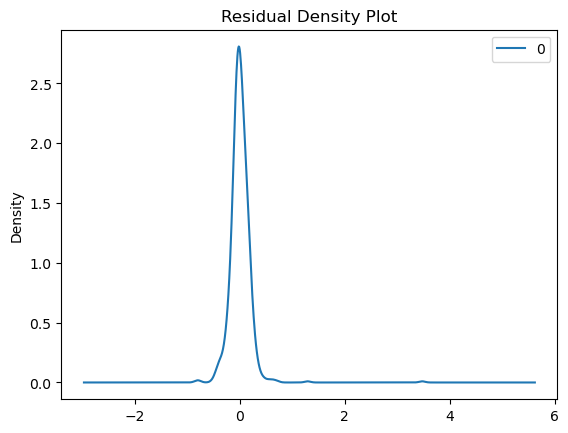

In [30]:
self_index = TRACE_OBJ_1.get_index(TEST_NEURON.label)

train = TRACE_OBJ_1.traces[self_index,:730]

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

fit = model_fit.fittedvalues
test = TRACE_OBJ_1.traces[self_index,730:]
preds = model_fit.forecast(len(TRACE_OBJ_1.traces[self_index])-730)
residuals = DataFrame(model_fit.resid)

# summary of fit model
print(model_fit.summary())

# RMSE
print("Fitted RMSE: %.3f" % np.sqrt(mean_squared_error(train, fit)), "explained variance:", 1 - (mean_squared_error(train, fit))/np.var(train))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)), "explained variance:", 1 - (mean_squared_error(train, fit))/np.var(train))

# == Fit ==
plot_trace(train, title=f"Training {TEST_NEURON.label} Calcium Trace ({trace_obj.uid})")
plot_trace(fit, title=f"Fitted {TEST_NEURON.label} Calcium Trace ({trace_obj.uid})")

# == Forecast ==
plot_trace(test, title=f"Test {TEST_NEURON.label} Calcium Trace ({trace_obj.uid})")
plot_trace(preds, title=f"Predicted {TEST_NEURON.label} Calcium Trace ({trace_obj.uid})")

# == residuals ==
plot_trace(residuals,  title="Training Residuals", ylabel="Residual")

# == density plot of residuals ==
residuals.plot(title="Residual Density Plot", kind='kde')

# summary stats of residuals
print(residuals.describe())

In [31]:
train, test = pm.model_selection.train_test_split(TRACE_OBJ_1.traces[self_index,:], train_size=730)
model = pm.auto_arima(train, 
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1879.757, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2333.488, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1167.070, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2400.426, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1472.557, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1085.106, Time=0.49 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1084.065, Time=0.23 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=1085.428, Time=0.59 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1883.280, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-472.912, Time=0.67 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-474.844, Time=0.20 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-472.917, Time=0.58 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-470.844, Time=1.23 sec
 ARIM

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 274.307
Date:                Fri, 01 Mar 2024   AIC                           -536.614
Time:                        12:22:47   BIC                           -509.064
Sample:                             0   HQIC                          -525.984
                                - 730                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0397      0.028      1.444      0.149      -0.014       0.094
ar.L2          0.1629      0.038      4.269      0.000       0.088       0.238
ar.L3          0.1420      0.037      3.799      0.0

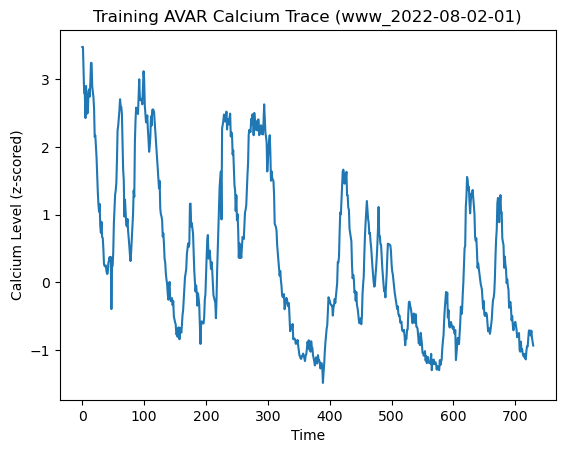

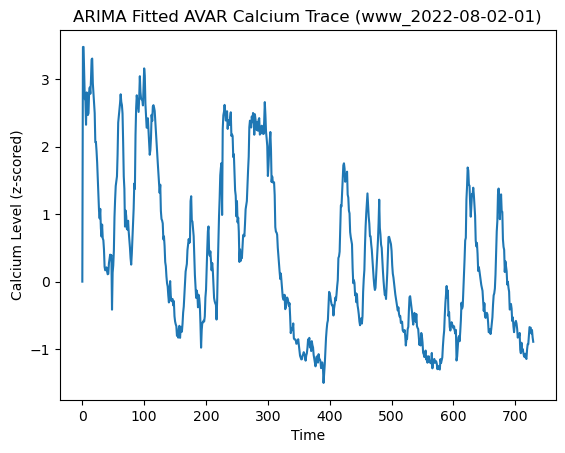

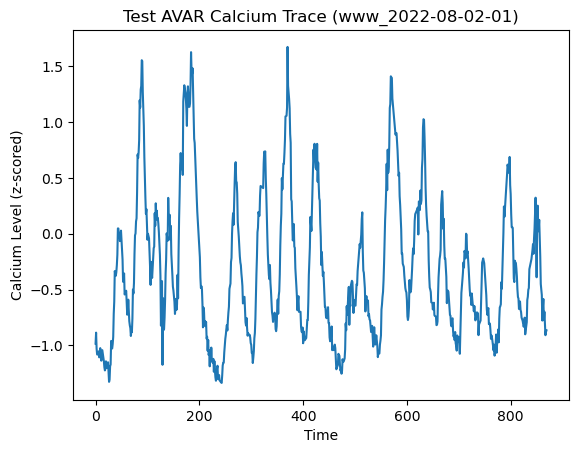

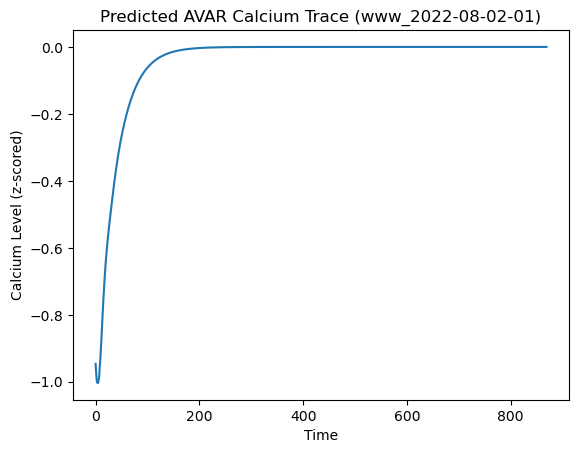

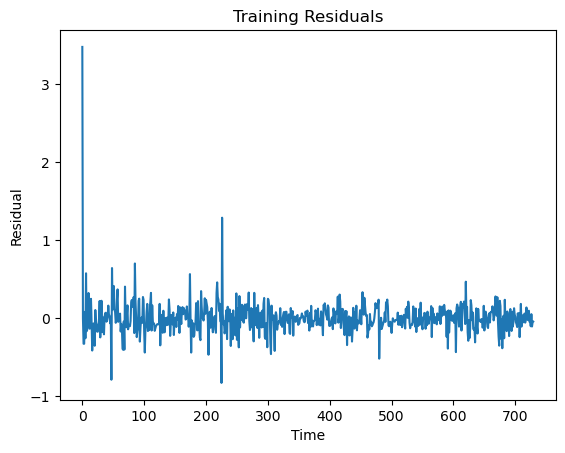

                0
count  730.000000
mean     0.001739
std      0.210123
min     -0.826684
25%     -0.088428
50%     -0.007717
75%      0.087777
max      3.474439


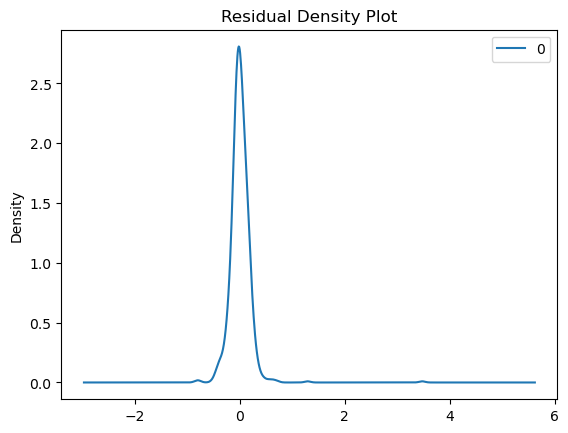

In [32]:
# print("Fitted RMSE: %.3f" % np.sqrt(mean_squared_error(train, fit)), "explained variance:", 1 - (mean_squared_error(train, fit))/np.var(train))
# print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)), "explained variance:", 1 - (mean_squared_error(test, preds))/np.var(test))

fit = model_fit.fittedvalues
preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)

# summary of fit model
print(model_fit.summary())

# RMSE
print("Fitted RMSE: %.3f" % np.sqrt(mean_squared_error(train, fit)))
print("explained variance:", 1 - (mean_squared_error(train, fit)/np.var(train)))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))
print(mean_squared_error(test, preds), np.var(test))
print("explained variance:", 1 - (mean_squared_error(test, preds)/np.var(test)))

# == Fit ==
plot_trace(train, title=f"Training {TEST_NEURON.label} Calcium Trace ({TRACE_OBJ_1.uid})")
plot_trace(fit, title=f"ARIMA Fitted {TEST_NEURON.label} Calcium Trace ({TRACE_OBJ_1.uid})")

# == Forecast ==
plot_trace(test, title=f"Test {TEST_NEURON.label} Calcium Trace ({TRACE_OBJ_1.uid})")
plot_trace(preds, title=f"Predicted {TEST_NEURON.label} Calcium Trace ({TRACE_OBJ_1.uid})")

# == residuals ==
plot_trace(residuals,  title="Training Residuals", ylabel="Residual")

# == density plot of residuals ==
residuals.plot(title="Residual Density Plot", kind='kde')

# summary stats of residuals
print(residuals.describe())

### Weird Tests

In [33]:
file_num = 0

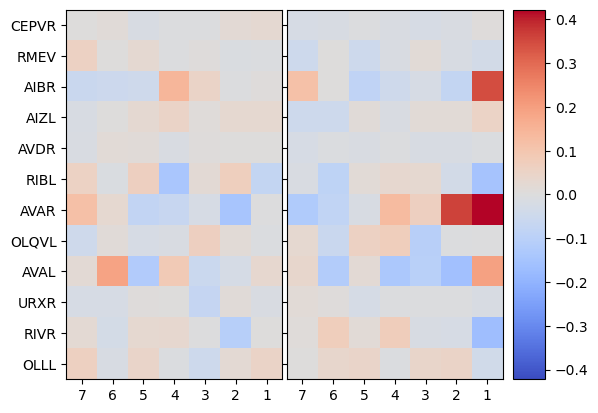

In [34]:
neuron = Neuron('AVER', w_rr=7, w_sr=1, context=CONTEXT_1)
fit_window = 700
num_timesteps = neuron.context.trace_obj.traces.shape[1]

# %matplotlib ipympl
fig = plt.figure()

def update(start):
    fig.clf()
    neuron.fit(w_rr=7, w_sr=1, window_start=10*start, window_width=fit_window, plot=False)
    neuron.visualize_c(fig=fig)

anim = FuncAnimation(fig, update, frames=90, interval=50)
anim.save(f'/u/ronakr/workspace/worms/figures/{neuron.label}-c-{neuron.context.trace_obj.uid} ({file_num}).gif', writer='imagemagick', fps=30)
file_num += 1

In [35]:
CONTEXT_1.trace_obj.get_index('RIMR')

-1

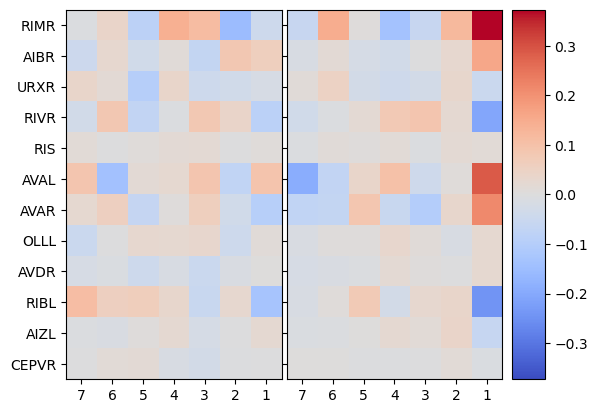

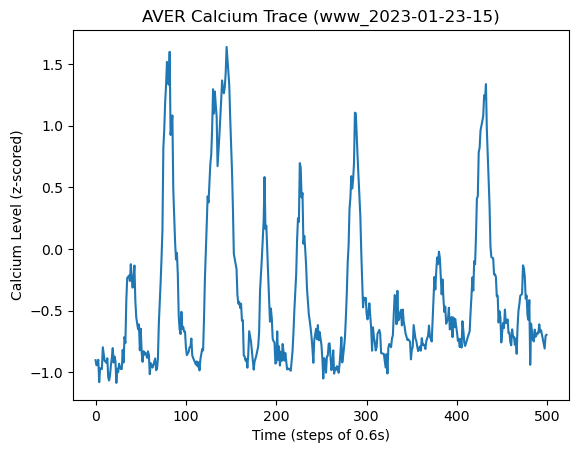

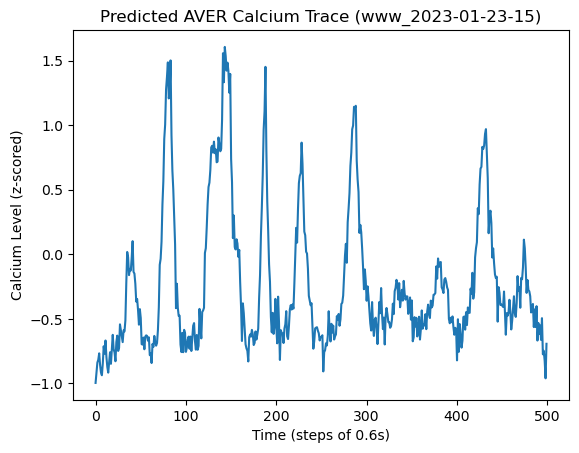

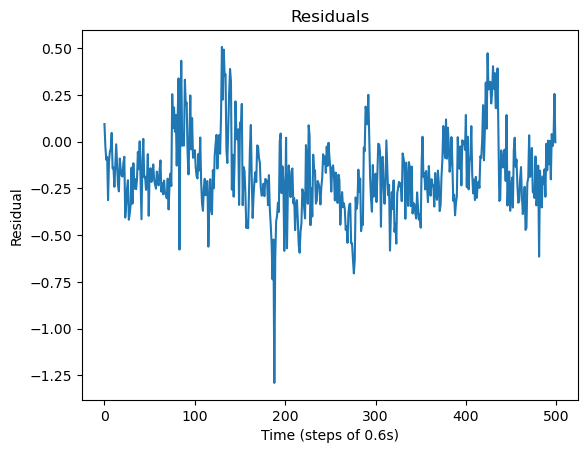

(predicting www_2023-01-23-15, start=1000, duration=500) Explained Variance: 0.8124687358913014


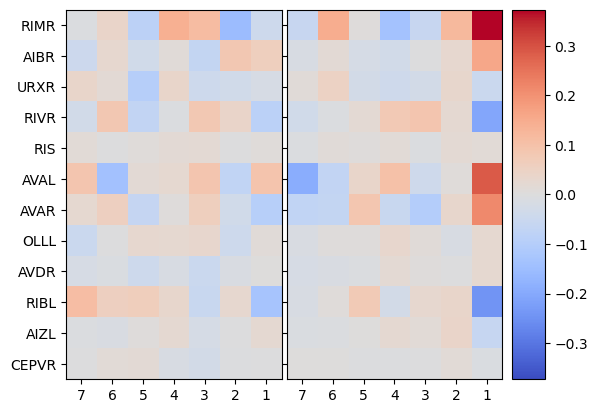

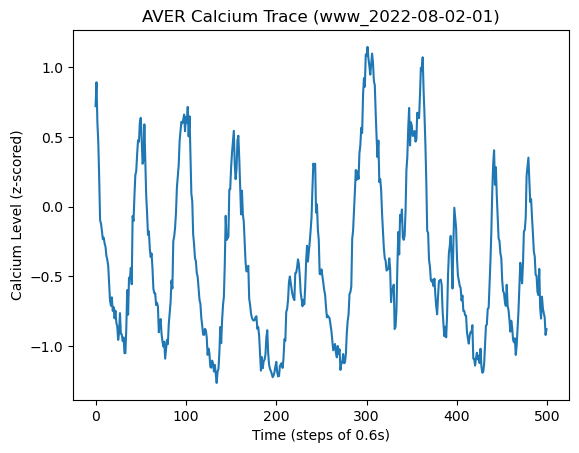

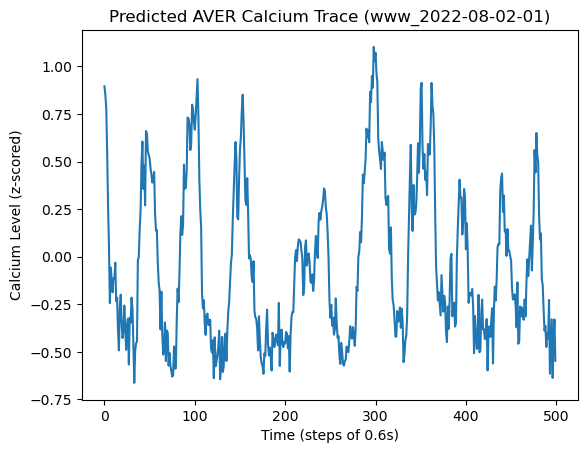

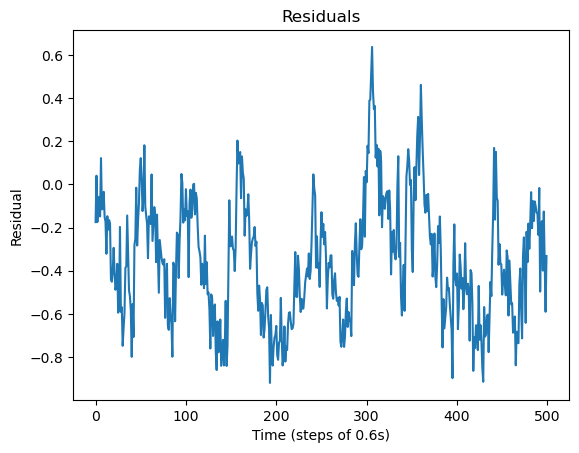

(predicting www_2022-08-02-01, start=1000, duration=500) Explained Variance: 0.4155446992477274


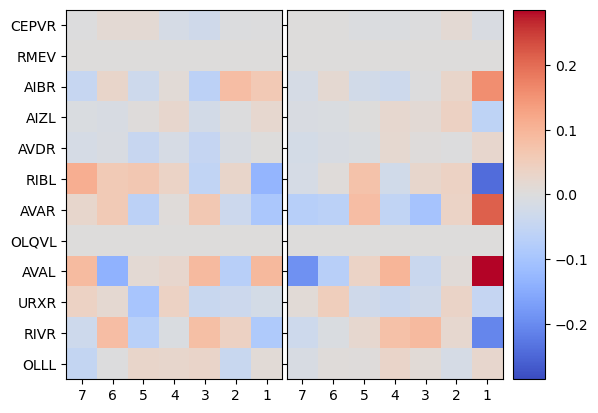

In [36]:
aver1 = Neuron('AVER', w_rr=7, w_sr=1, context=CONTEXT_1)
aver2 = Neuron('AVER', w_rr=7, w_sr=1, context=CONTEXT_2)

# aver1.fit(w_rr=7, w_sr=1, window_start=0, window_width=1000, plot=False)
aver2.fit(w_rr=7, w_sr=1, window_start=0, window_width=1000, plot=False)

# aver1.visualize_c()
aver2.visualize_c()

# CONTEXT_1.predict(aver1, 1000, 500)
CONTEXT_2.predict(aver2, 1000, 500)
# aver1.visualize_c()
aver2.visualize_c()

# CONTEXT_2.predict(aver1, 1000, 500)
CONTEXT_1.predict(aver2, 1000, 500)
# aver1.visualize_c()
aver2.visualize_c()

## TODO notes: 

- https://github.com/dadadel/pyment
- try ridge regression/regularization
- modify to do online learning
- email 
  - Andrew Leifer: http://leiferlab.princeton.edu/
  - Steve Flavell: https://flavell.mit.edu/steven/
  - Eviatar Yemini: https://www.yeminilab.com/

Does chaos theory offer an insurmountable obstacle? Might want to try a neural net as a benchmark for how well any model might be expected to fit the data.